(mmm_time_slice_cross_validation)=
# Time-Slice-Cross Validation and Stability for Media Mix Models

In this notebook we will illustrate how to perform time-slice cross validation for a media mix model. This is an importnt step to evaluate the stability and quality of the model. We not only look into out of sample predictions but also the stability of the model parameters.

## Prepare Notebook

In [ ]:
import warnings
from dataclasses import dataclass

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from pymc_marketing.metrics import crps
from pymc_marketing.mmm.delayed_saturated_mmm import (
    MMM,
    GeometricAdstock,
    LogisticSaturation,
)
from pymc_marketing.mmm.utils import apply_sklearn_transformer_across_dim
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We use the same data as in the example notebook {ref}`mmm_example`.

In [3]:
data_path = data_dir / "mmm_example.csv"

data_df = pd.read_csv(data_path, parse_dates=["date_week"])

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_week  179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


## Specify Time-Slice-Cross-Validation Strategy

In [4]:
def compute_sigma_from_costs(
    X: pd.DataFrame, channel_columns: list[str]
) -> list[float]:
    n_channels = len(channel_columns)
    total_spend_per_channel = X[channel_columns].sum(axis=0)
    spend_share = total_spend_per_channel / total_spend_per_channel.sum()
    prior_sigma = n_channels * spend_share.to_numpy()
    return prior_sigma.tolist()


def get_mmm(X: pd.DataFrame, channel_columns: list[str]) -> MMM:
    prior_sigma = compute_sigma_from_costs(X, channel_columns)

    model_config = {
        "saturation_beta": Prior("HalfNormal", sigma=prior_sigma, dims="channel"),
    }

    return MMM(
        adstock=GeometricAdstock(l_max=8),
        saturation=LogisticSaturation(),
        date_column="date_week",
        channel_columns=channel_columns,
        control_columns=[
            "event_1",
            "event_2",
            "t",
        ],
        yearly_seasonality=2,
        model_config=model_config,
    )


def fit_mmm(
    mmm: MMM, X: pd.DataFrame, y: pd.Series, random_seed: np.random.Generator
) -> MMM:
    fit_kwargs = {
        "tune": 1_000,
        "chains": 4,
        "draws": 1_000,
        "nuts_sampler": "numpyro",
        "target_accept": 0.9,
        "random_seed": random_seed,
    }
    _ = mmm.fit(X, y, progressbar=False, **fit_kwargs)
    _ = mmm.sample_posterior_predictive(
        X, extend_idata=True, combined=True, progressbar=False, random_seed=random_seed
    )
    return mmm

In [5]:
@dataclass
class TimeSliceCrossValidationResult:
    """Container for the results of the time slice cross validation."""

    X_train: pd.DataFrame
    y_train: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series
    mmm: MMM
    y_pred_test: pd.Series


def time_slice_cross_validation_step(
    X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series
) -> TimeSliceCrossValidationResult:
    mmm = get_mmm(X_train, channel_columns=["x1", "x2"])
    mmm = fit_mmm(mmm, X_train, y_train, rng)

    y_pred_test = mmm.sample_posterior_predictive(
        X_pred=X_test,
        include_last_observations=True,
        original_scale=True,
        extend_idata=False,
    )

    return TimeSliceCrossValidationResult(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        mmm=mmm,
        y_pred_test=y_pred_test,
    )

## Run Time-Slice-Cross-Validation Loop

In [6]:
X = data_df[["date_week", "x1", "x2", "event_1", "event_2", "t"]]
y = data_df["y"]

In [7]:
n_init = 158
forecast_horizon = 12
n_iterations = y.size - n_init - forecast_horizon + 1

In [ ]:
results: list[TimeSliceCrossValidationResult] = []


for iteration in tqdm(range(n_iterations)):
    # Split data into train and test
    train_test_split = iteration + n_init
    X_train = X.iloc[:train_test_split]
    y_train = y.iloc[:train_test_split]
    X_test = X.iloc[train_test_split : train_test_split + forecast_horizon]
    y_test = y.iloc[train_test_split : train_test_split + forecast_horizon]

    step = time_slice_cross_validation_step(X_train, y_train, X_test, y_test)
    results.append(step)

## Evaluate Parameter Stability

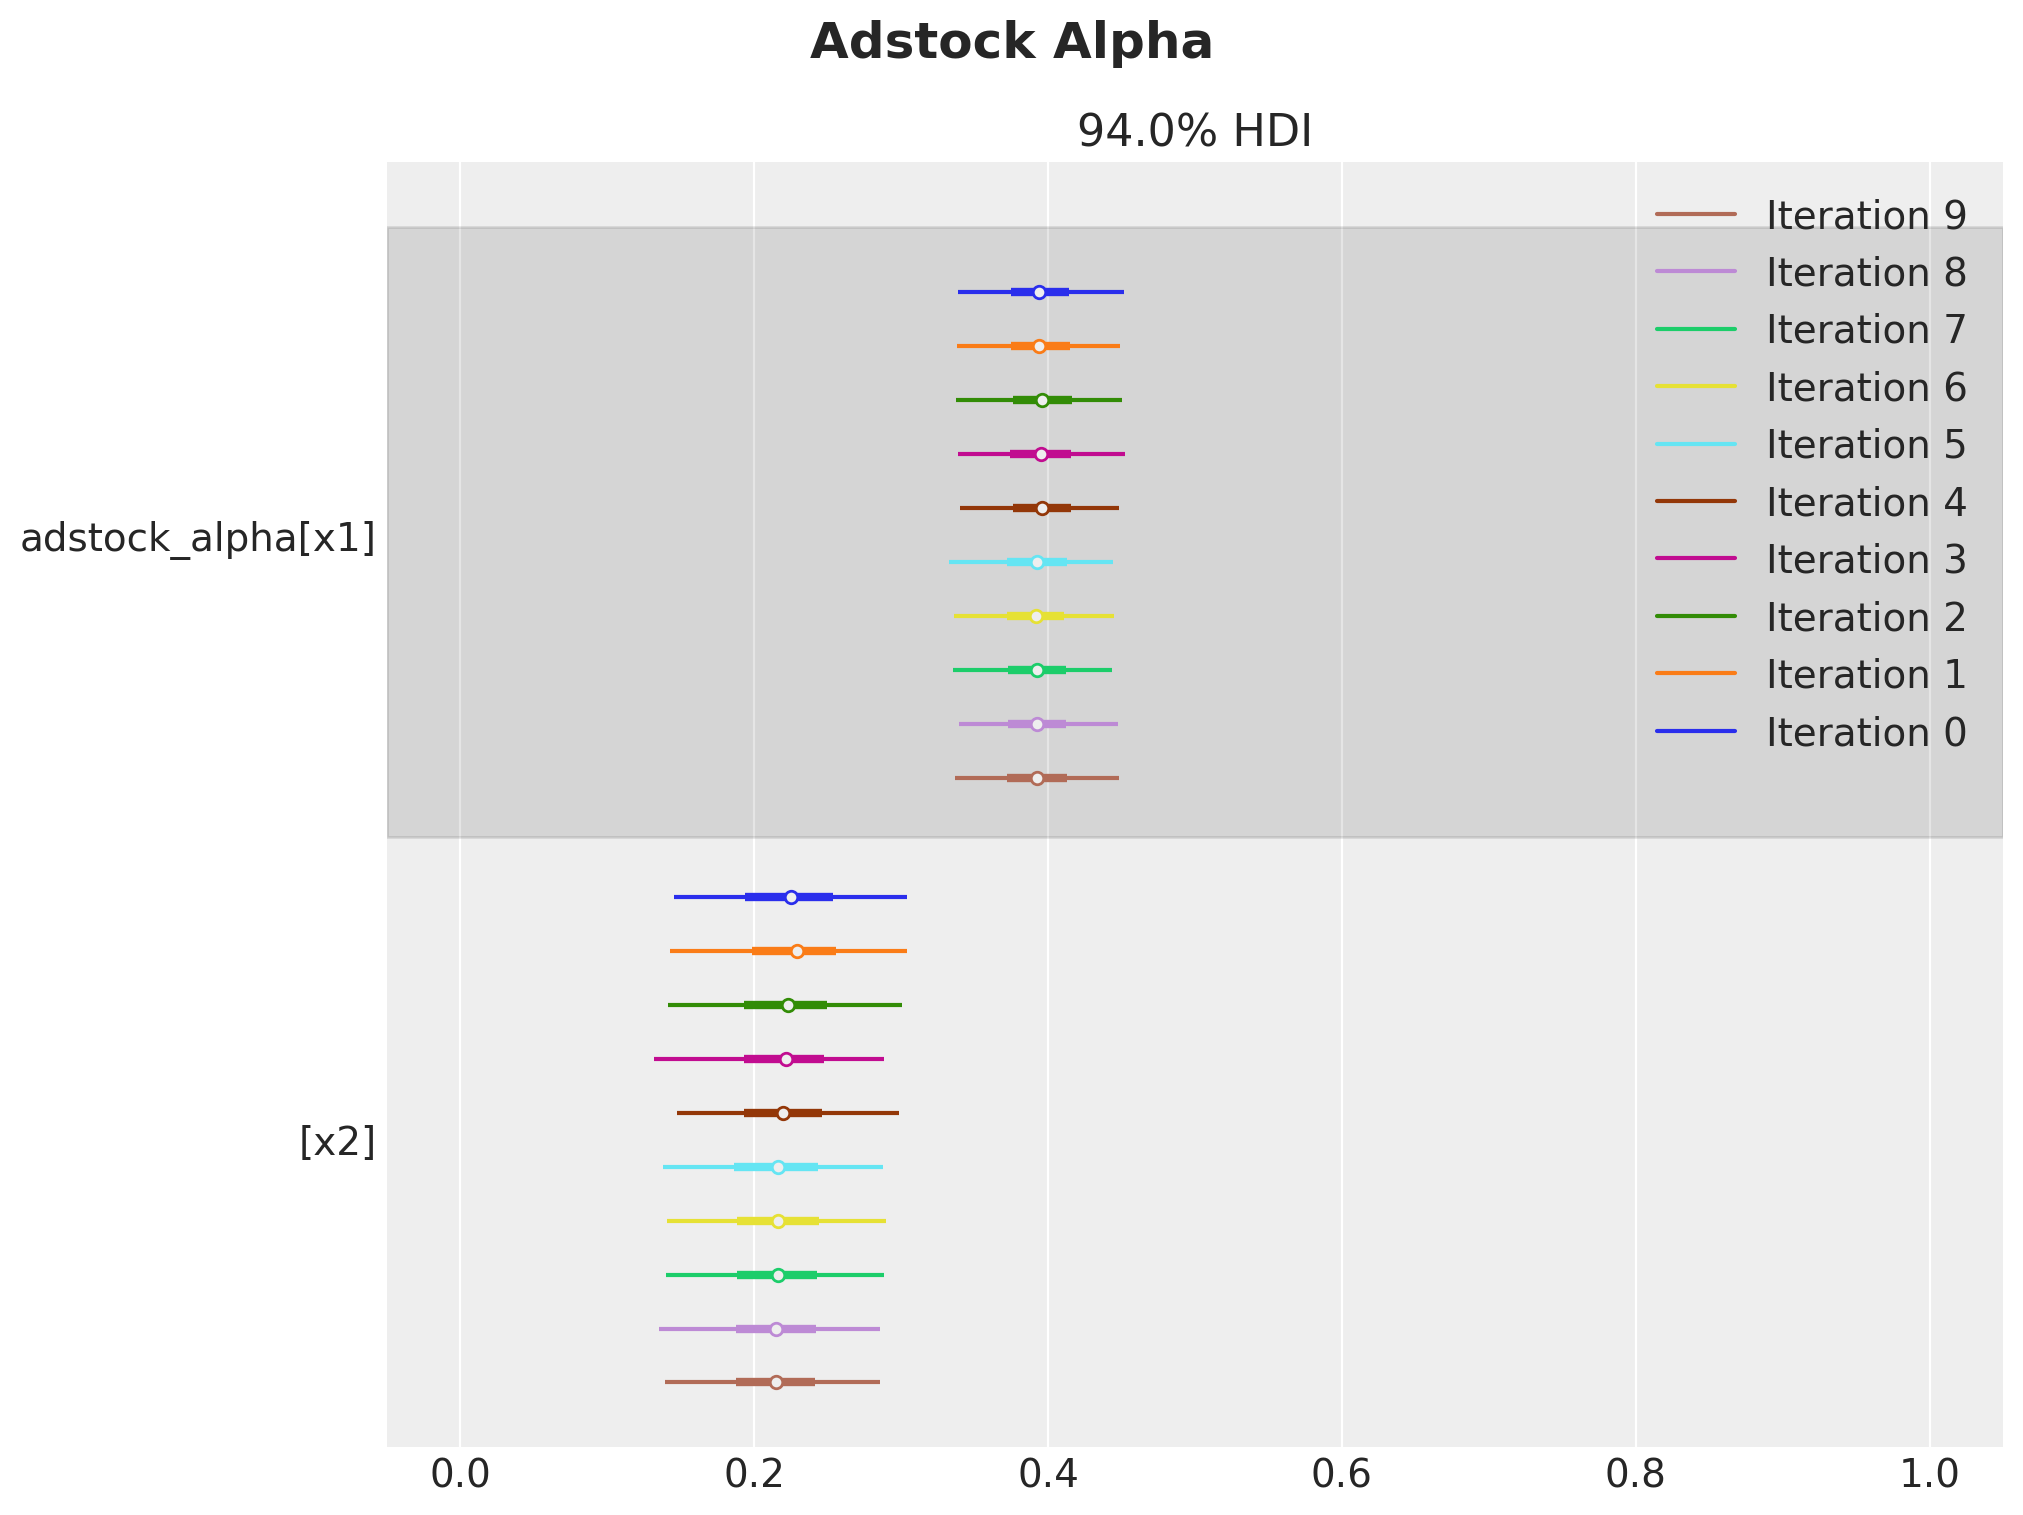

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"Iteration {i}" for i in range(n_iterations)],
    var_names=["adstock_alpha"],
    combined=True,
    ax=ax,
)
fig.suptitle("Adstock Alpha", fontsize=18, fontweight="bold", y=1.06);

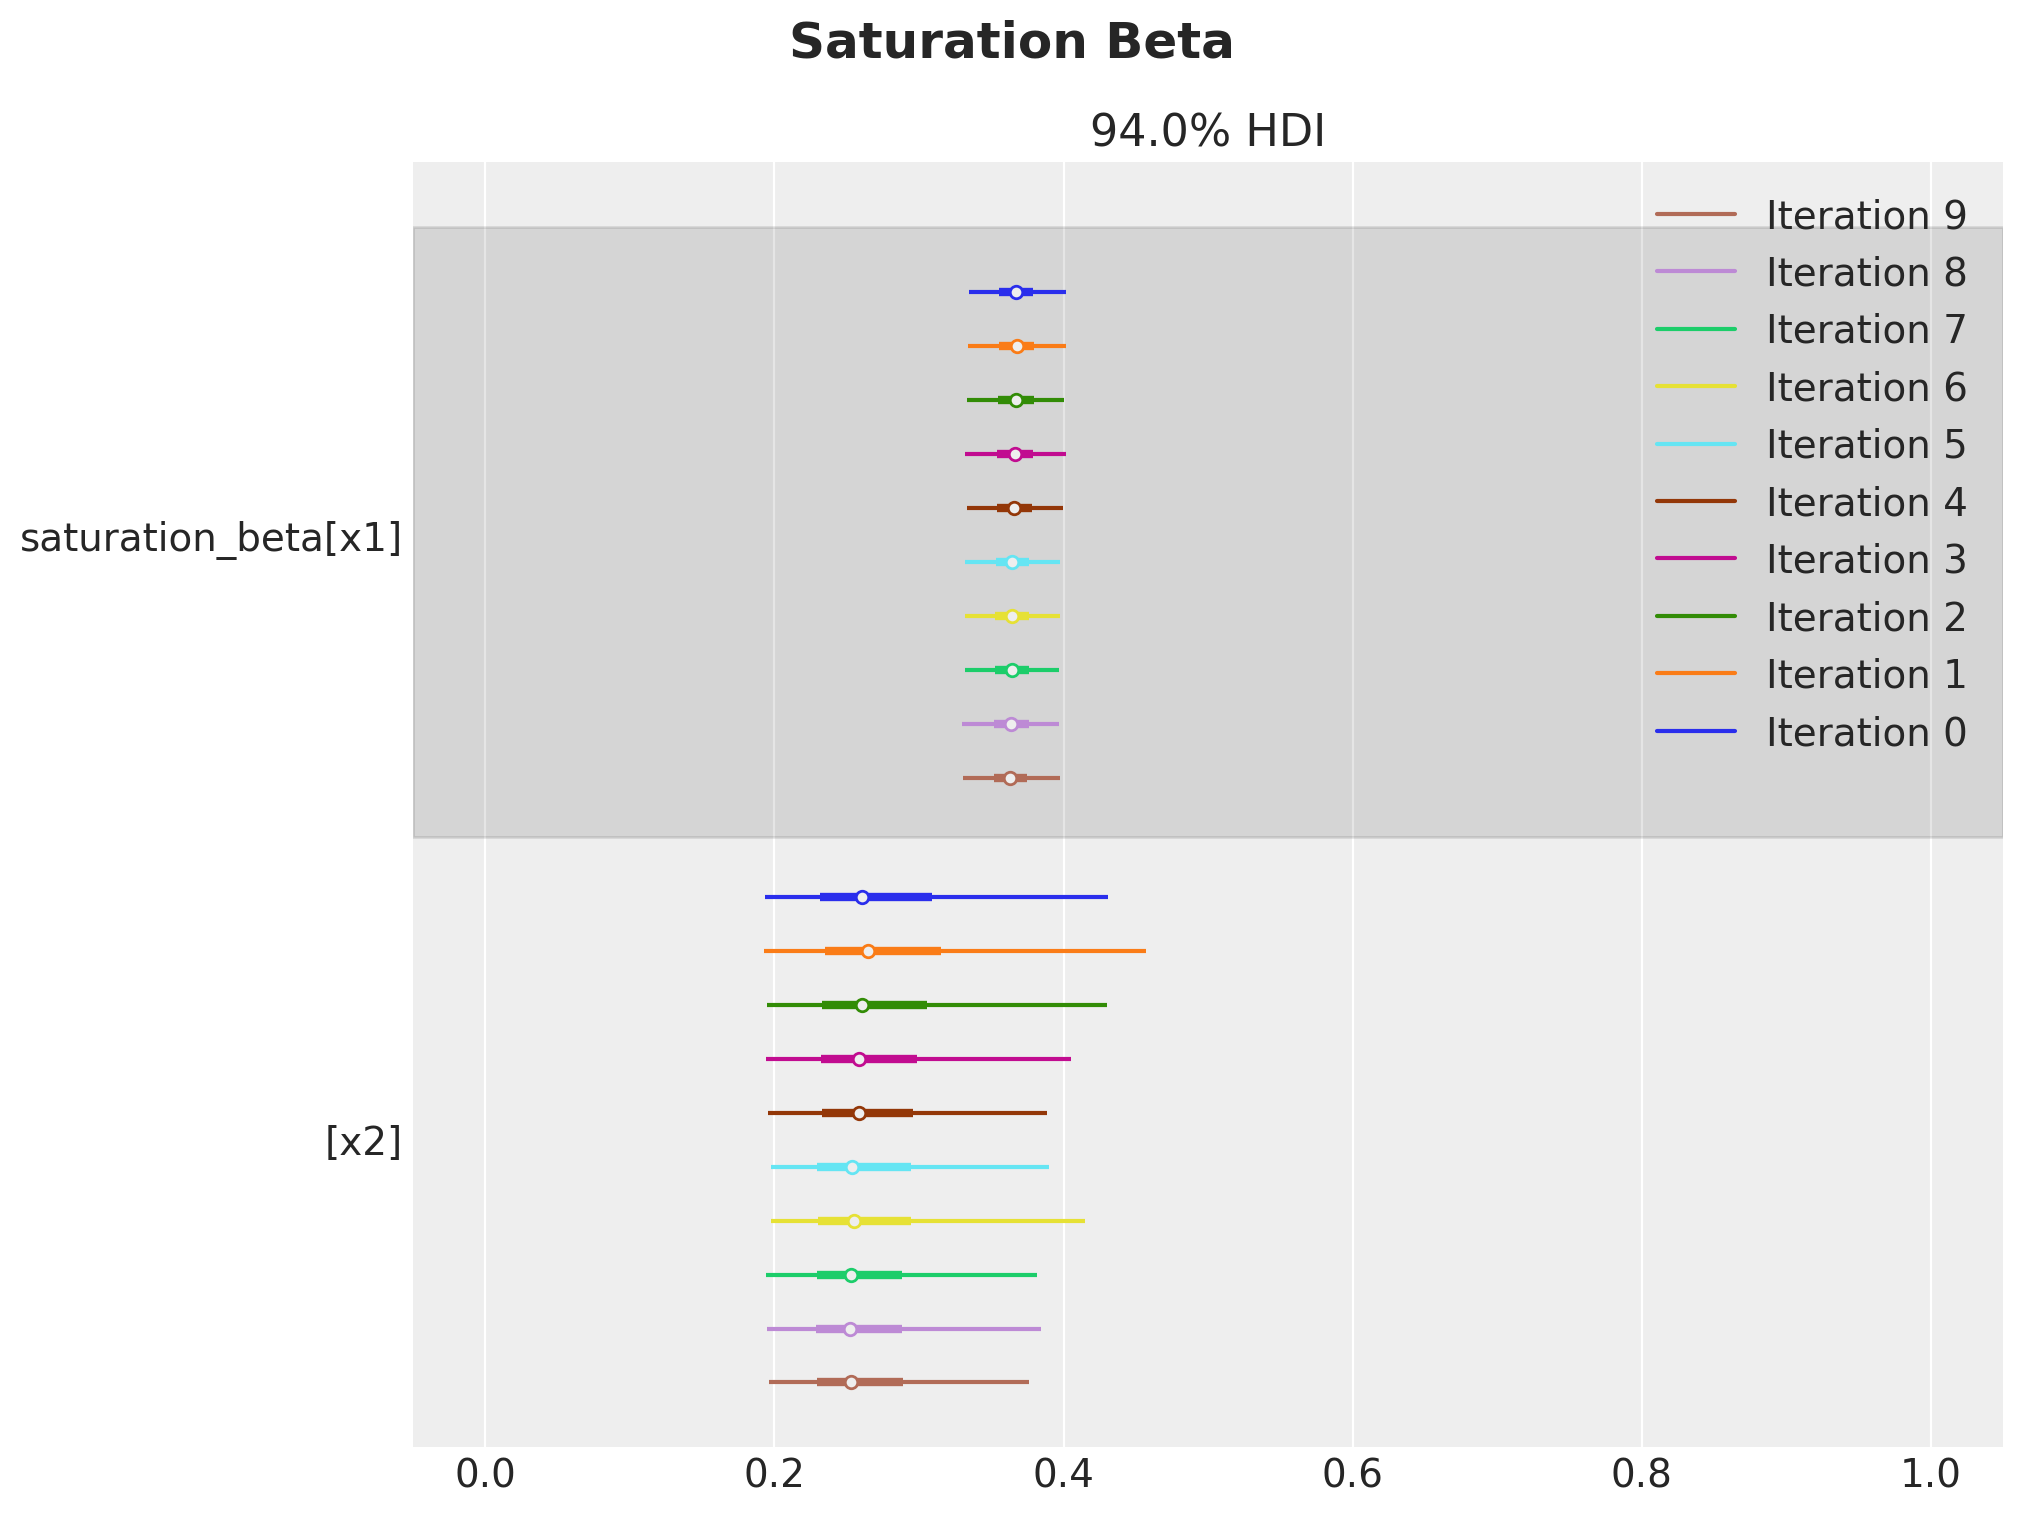

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"Iteration {i}" for i in range(n_iterations)],
    var_names=["saturation_beta"],
    combined=True,
    ax=ax,
)
fig.suptitle("Saturation Beta", fontsize=18, fontweight="bold", y=1.06);

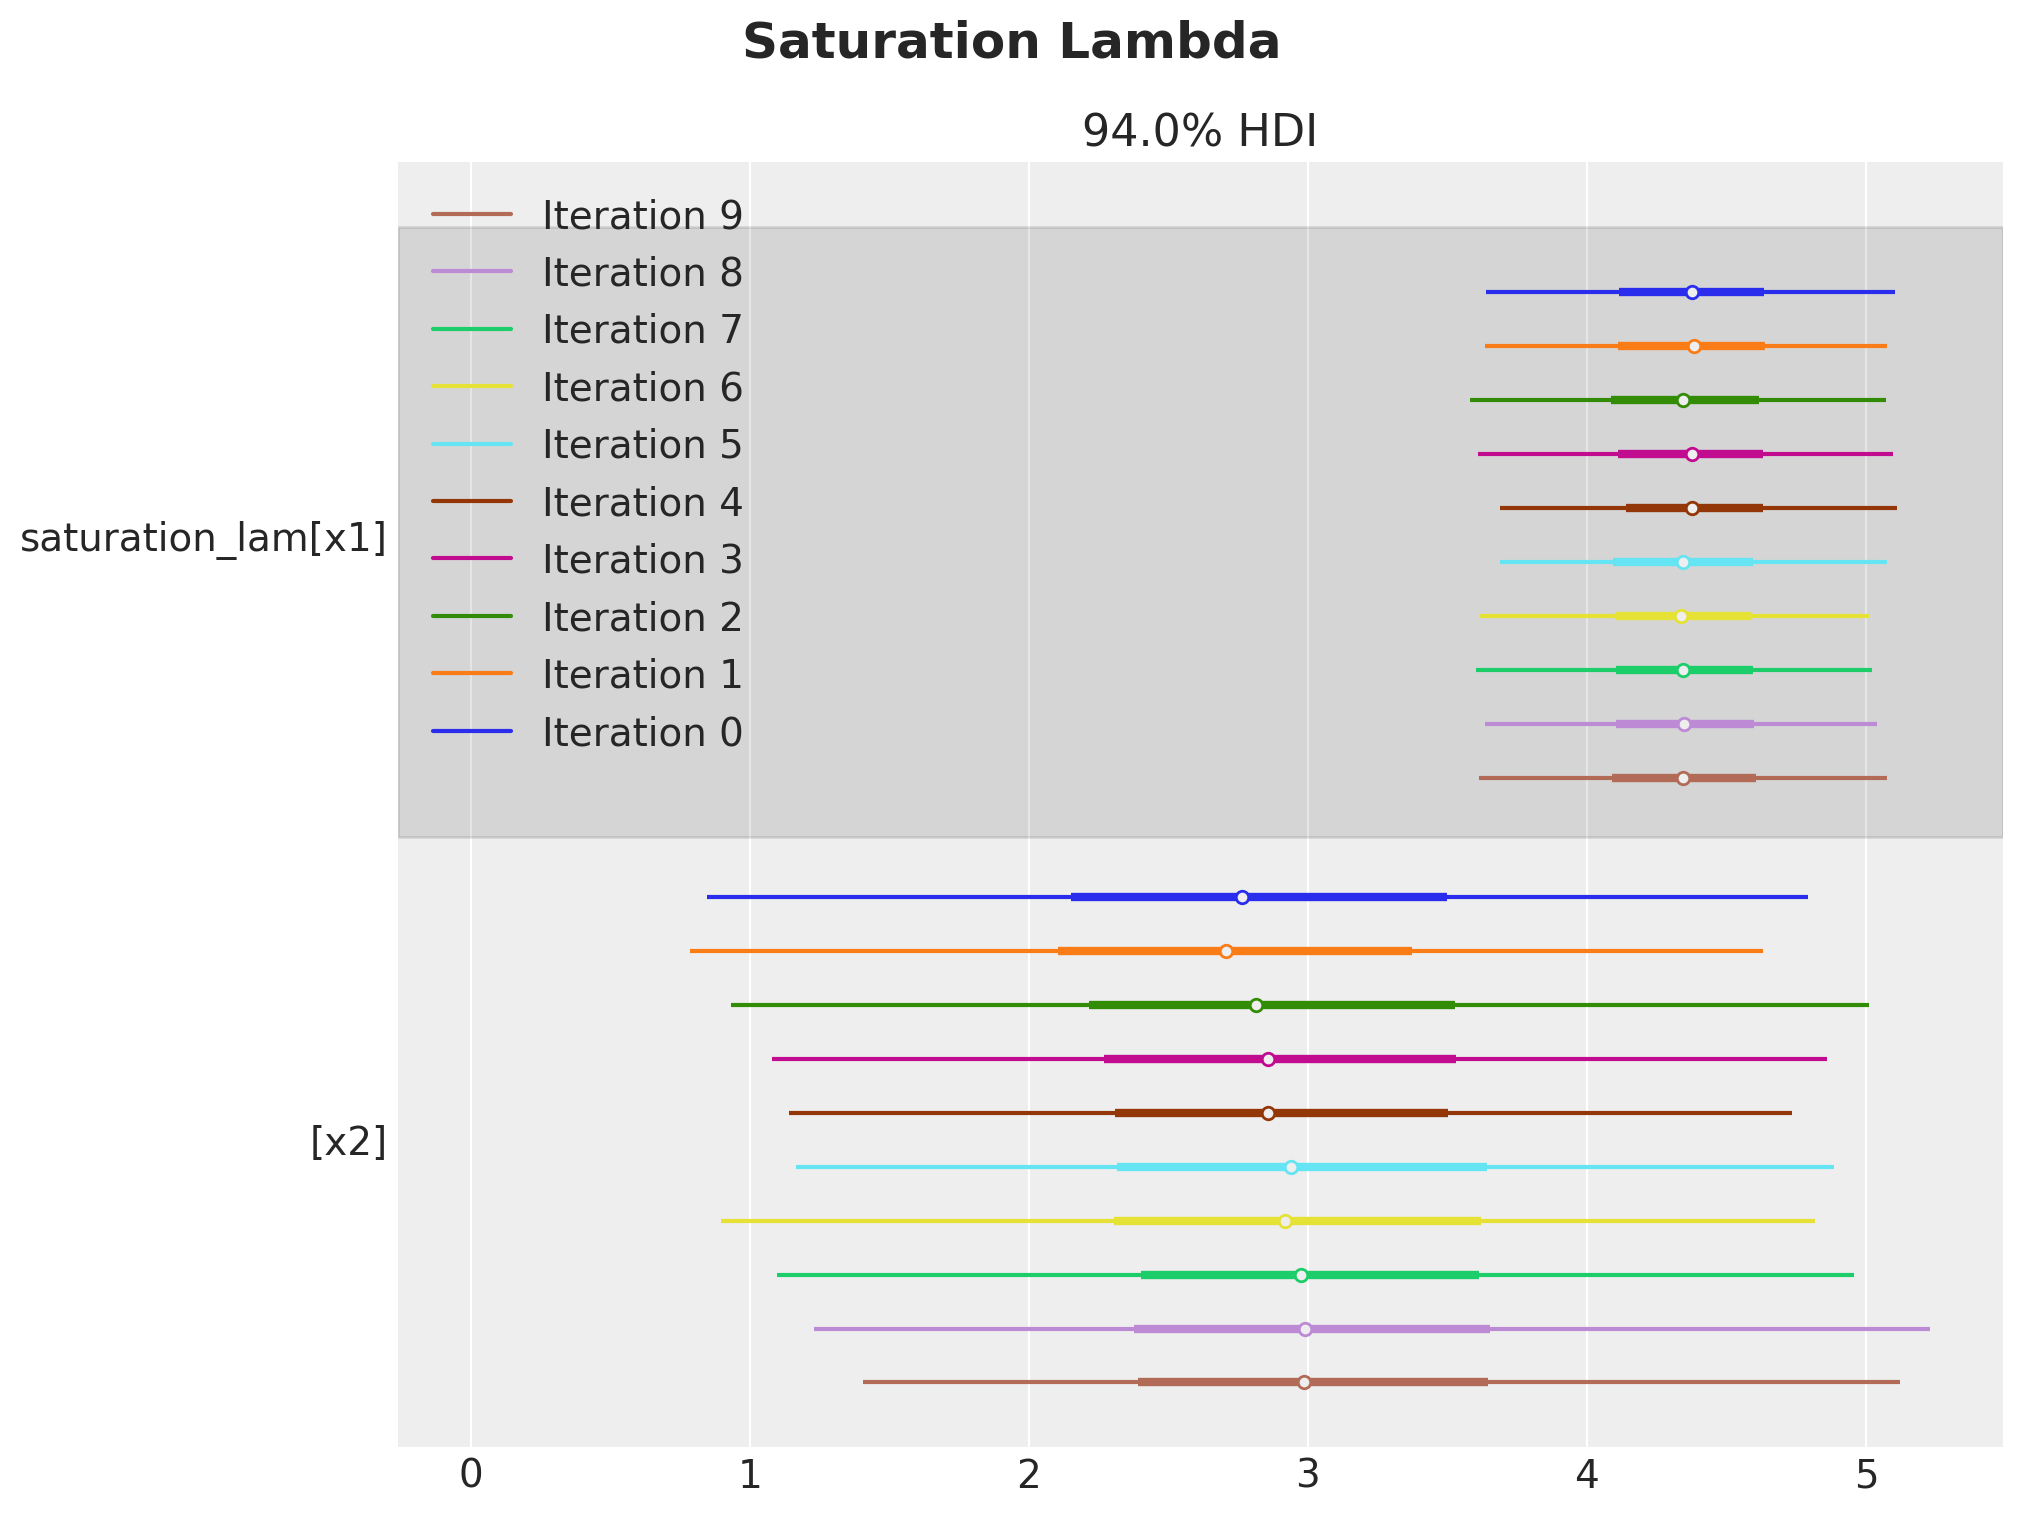

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

az.plot_forest(
    data=[result.mmm.idata["posterior"] for result in results],
    model_names=[f"Iteration {i}" for i in range(n_iterations)],
    var_names=["saturation_lam"],
    combined=True,
    ax=ax,
)
fig.suptitle("Saturation Lambda", fontsize=18, fontweight="bold", y=1.06);

## Evaluate Out of Sample Predictions

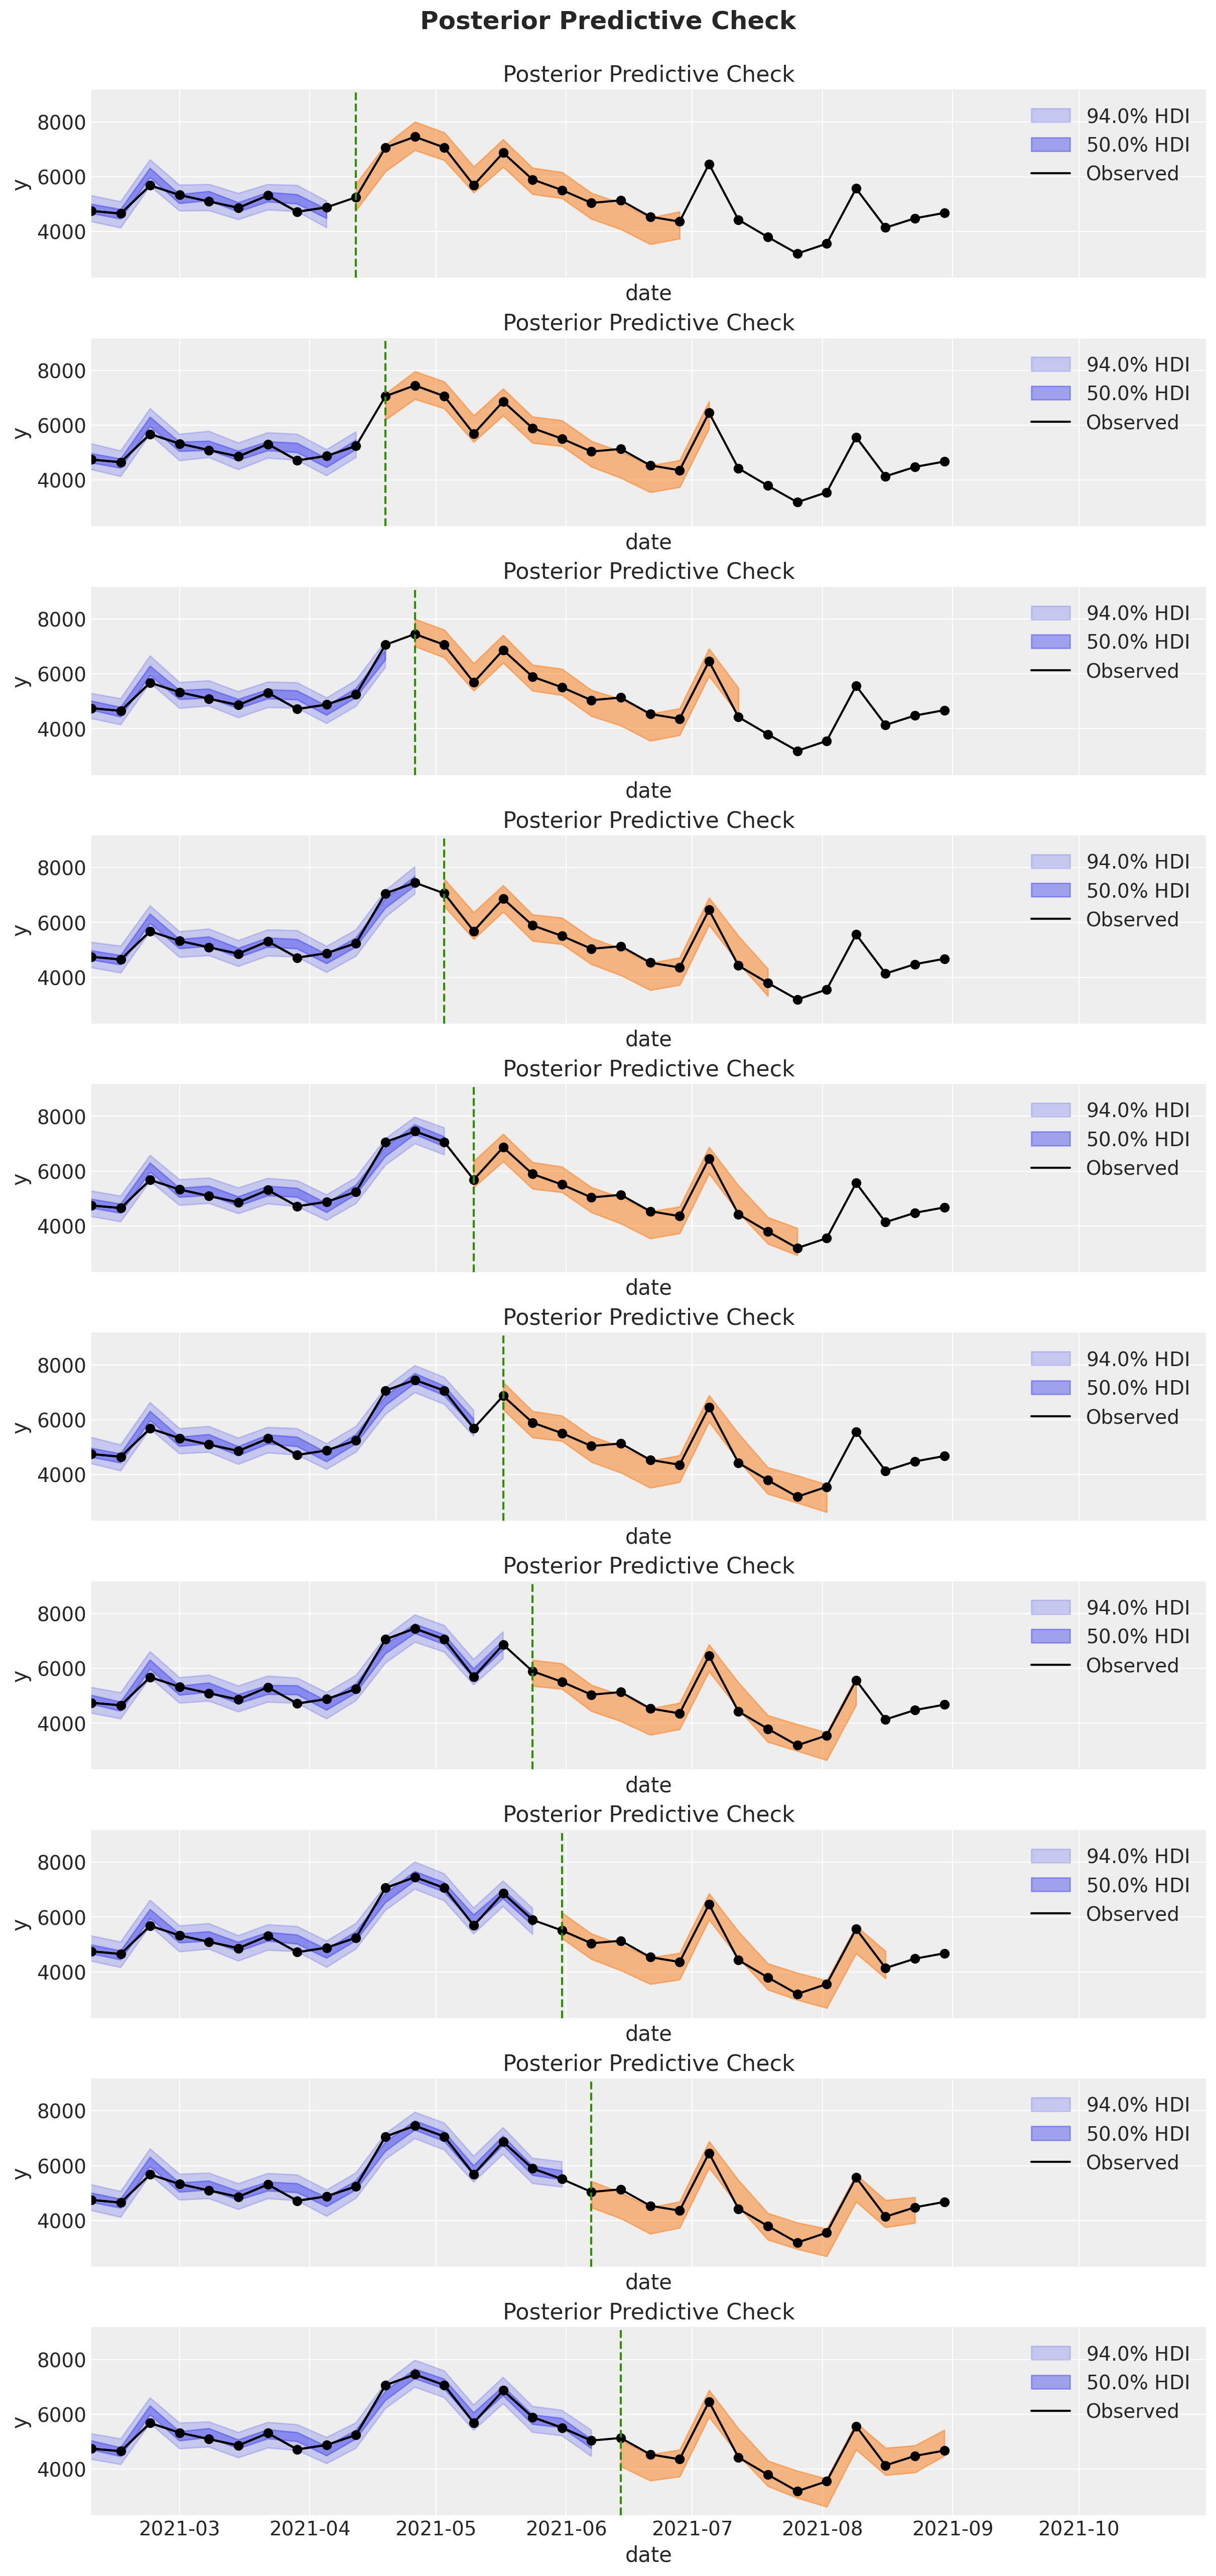

In [12]:
fig, axes = plt.subplots(
    nrows=n_iterations,
    ncols=1,
    figsize=(12, 25),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.ravel()

for i, result in enumerate(results):
    ax = axes[i]
    result.mmm.plot_posterior_predictive(original_scale=True, ax=ax)

    test_hdi = az.hdi(result.y_pred_test["y"].to_numpy().T)

    ax.fill_between(
        result.X_test["date_week"],
        test_hdi[:, 0],
        test_hdi[:, 1],
        color="C1",
        alpha=0.5,
    )
    ax.plot(X["date_week"], y, marker="o", color="black")
    ax.axvline(result.X_test["date_week"].iloc[0], color="C2", linestyle="--")

axes[-1].set(xlim=(X["date_week"].iloc[n_init - 9], None))
fig.suptitle("Posterior Predictive Check", fontsize=18, fontweight="bold", y=1.02);

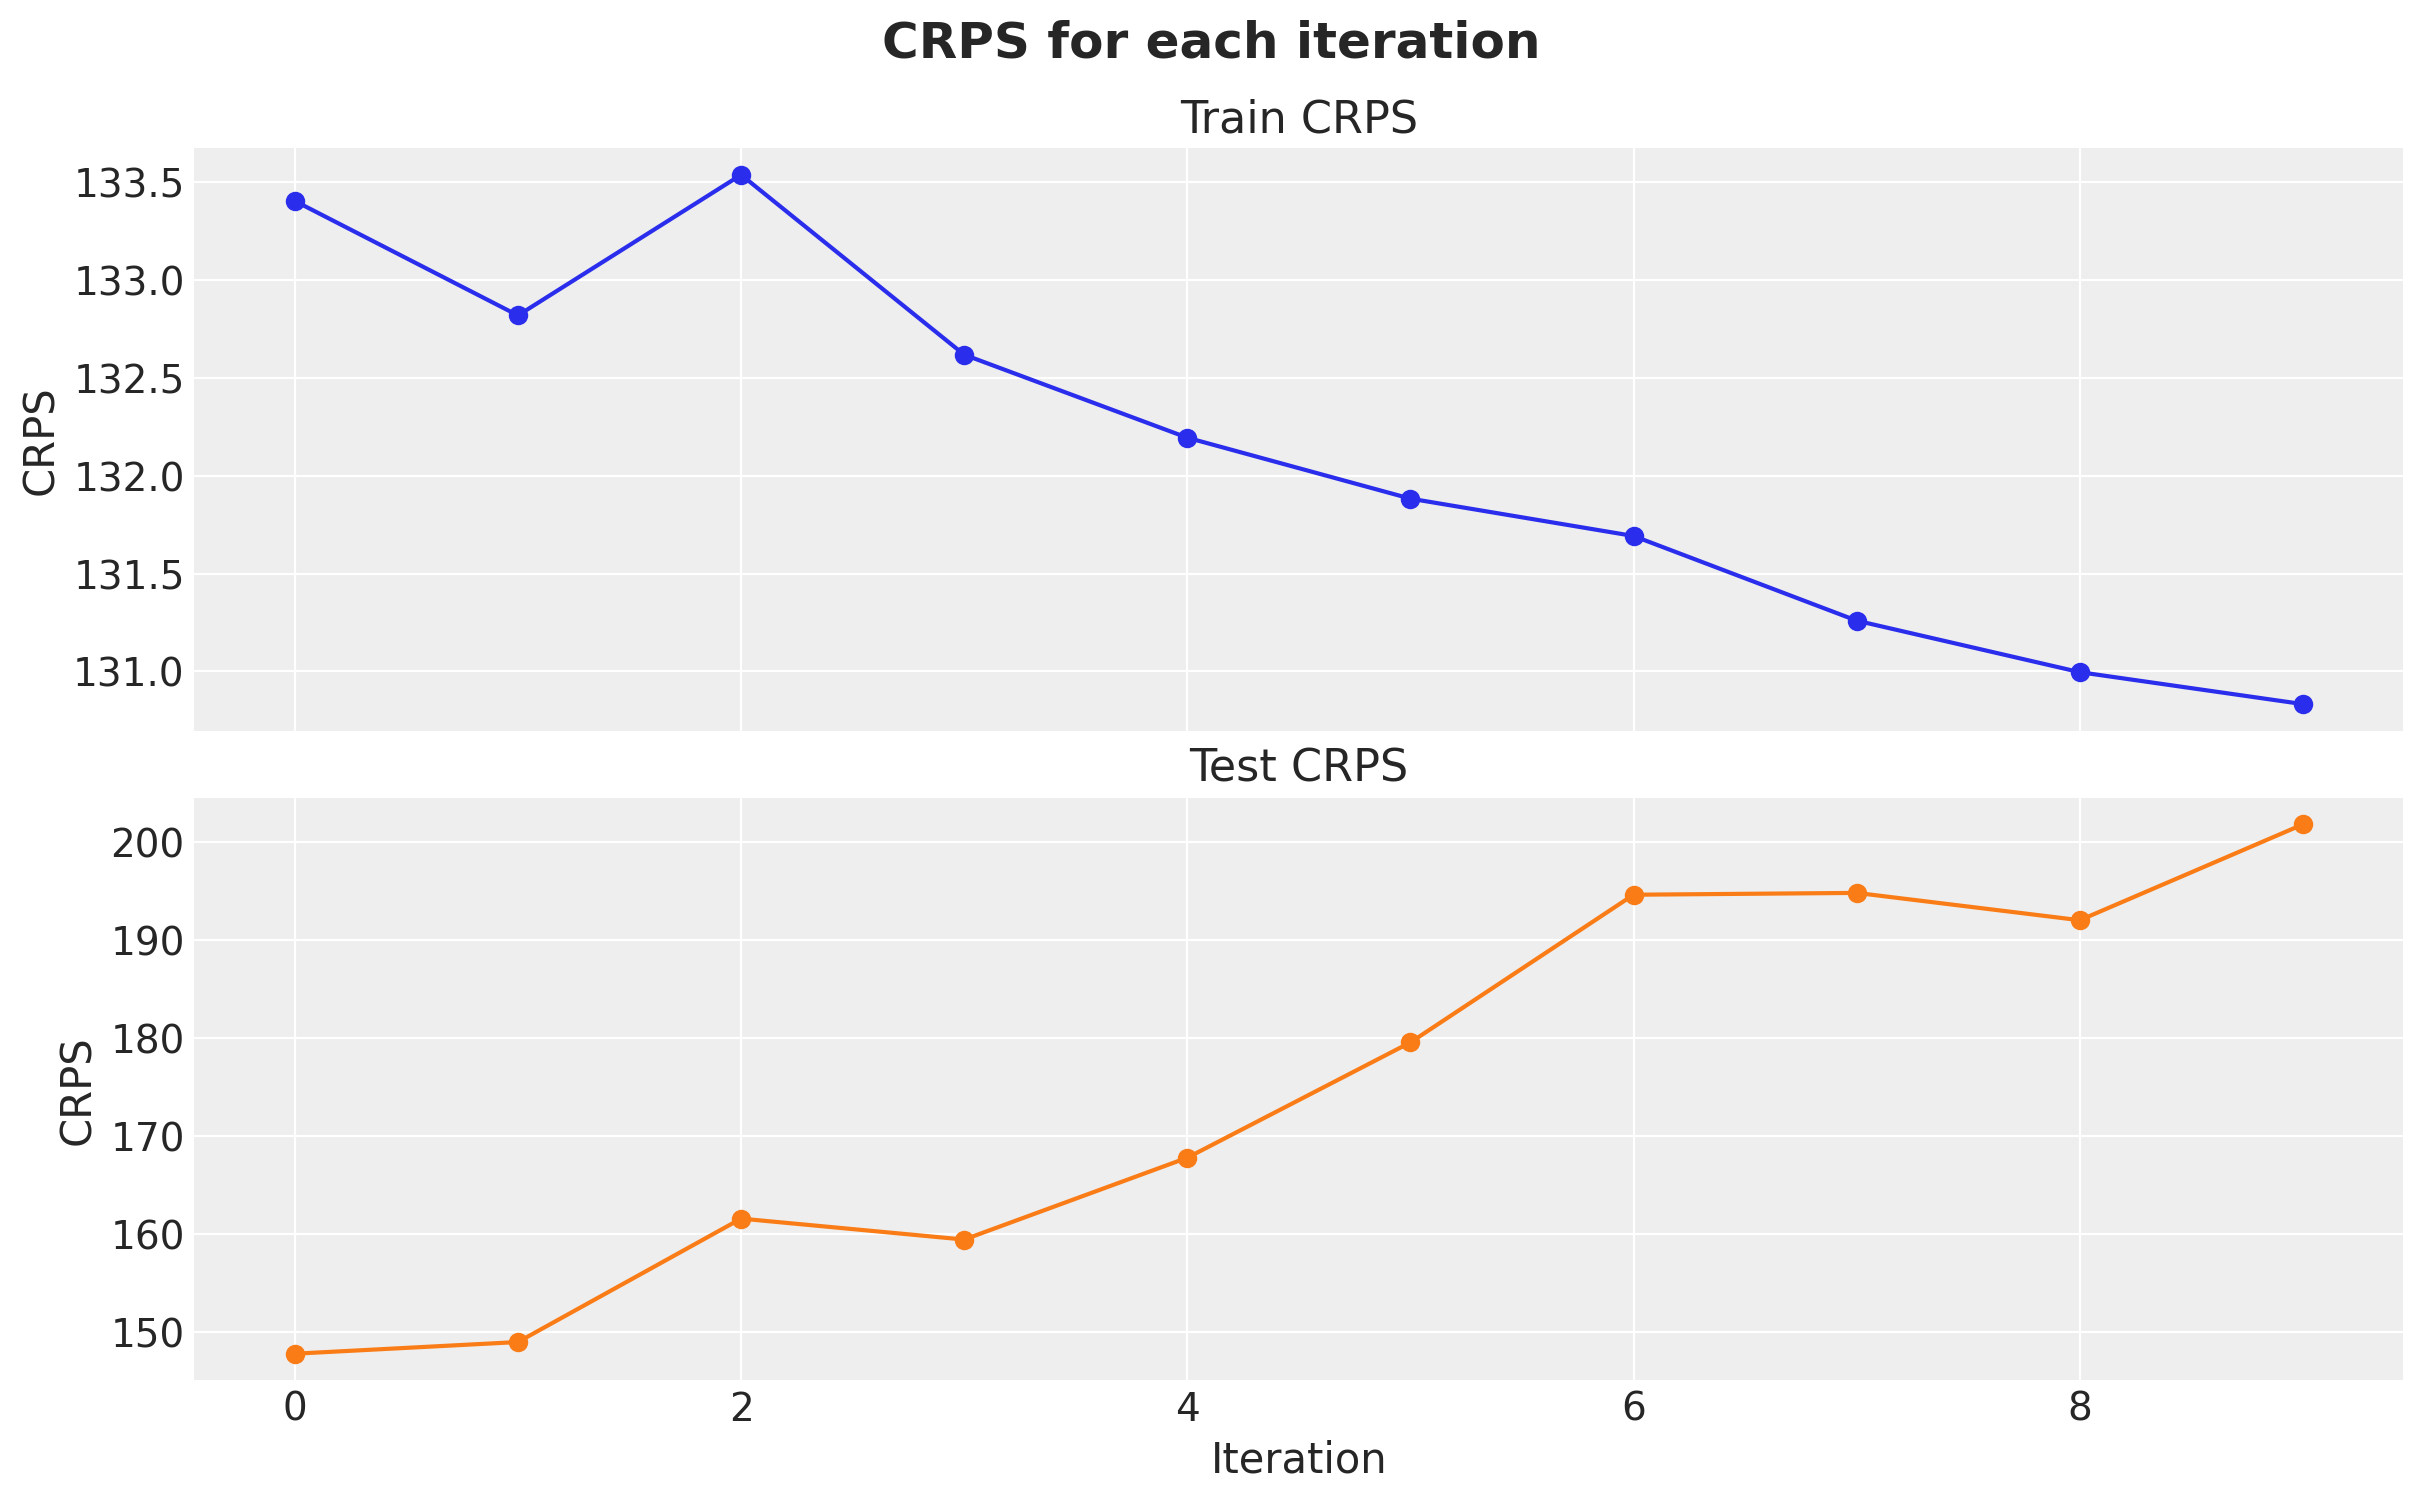

In [13]:
crps_results_train = [
    crps(
        y_true=result.y_train.to_numpy(),
        y_pred=az.extract(
            # Scale the predictions back to the original scale
            apply_sklearn_transformer_across_dim(
                data=result.mmm.idata.posterior_predictive["y"],
                func=result.mmm.get_target_transformer().inverse_transform,
                dim_name="date",
            )
        )["y"]
        .to_numpy()
        .T,
    )
    for result in results
]


crps_results_test = [
    crps(
        y_true=result.y_test.to_numpy(),
        y_pred=result.y_pred_test["y"].to_numpy().T,
    )
    for result in results
]

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)

ax[0].plot(crps_results_train, marker="o", color="C0", label="train")
ax[0].set(ylabel="CRPS", title="Train CRPS")
ax[1].plot(crps_results_test, marker="o", color="C1", label="test")
ax[1].set(xlabel="Iteration", ylabel="CRPS", title="Test CRPS")
fig.suptitle("CRPS for each iteration", fontsize=18, fontweight="bold", y=1.05);